# Emotion Detection System using AVEC 2018

## I mapped valence and arousasal into the four emotion zones using this reference: 
```
    @article{tan2019automatic,
  title={Automatic music mood recognition using Russell’s twodimensional valence-arousal space from audio and lyrical data as classified using SVM and Na{\"\i}ve Bayes},
 author={Tan, KR and Villarino, ML and Maderazo, C},
  journal={MS\&E},
  volume={482},
  number={1},
  pages={012019},
  year={2019}
} ```
### Two dimensional valence-arousal space
![alt text](valence_arousal.png "Two dimensional valence-arousal space")

### I took some decisions when we find values over orthogonal axis 
1. the point (0,0) is green
2. the point (0,1) is yellow
3. the point (1,0) is green
4. the point (0,-1) is blue
5. the point (-1,0) is red 

Following the same logic, I defined that:
1. when the values rest on the valence axis (arousal value equals 0), 
  * If valence value is positive (valence greater than 0): green class 
  * Else (valence less than 0): red class 


2. when the values rest on the arousal axis (valence value equals 0), 
  * If arousal value is positive (arousal greater than 0): yellow class 
  * Else (arousal less than 0): blue class 

In [20]:
import glob
import pathlib
import os.path

import pandas as pd

path_annotation_emotions = '/Users/user/PycharmProjects/emotion_detection_system/labels/emotion_zones/emotion_names'
files = glob.glob(f"{path_annotation_emotions}/*.csv")
train_count = {'yellow': 0, 'red': 0, 'blue': 0, 'green': 0}
dev_count = {'yellow': 0, 'red': 0, 'blue': 0, 'green': 0}
for file in files:
    df_train = pd.read_csv(file)
    df_train['emotion_zone'].value_counts()
    count_emotions = df_train['emotion_zone'].value_counts()
    if 'train' in file:
        train_count['yellow'] += count_emotions['yellow']
        train_count['red'] += count_emotions['red']
        train_count['blue'] += count_emotions['blue']
        train_count['green'] += count_emotions['green']
    elif 'dev' in file:
        dev_count['yellow'] += count_emotions['yellow']
        dev_count['red'] += count_emotions['red']
        dev_count['blue'] += count_emotions['blue']
        dev_count['green'] += count_emotions['green']

## We then computed statistics to find emotion zones distribution into train and dev datasets. 

### Class Distribution within all train dataset

<BarContainer object of 4 artists>

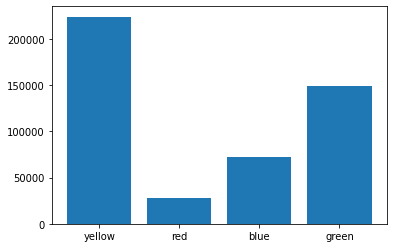

In [21]:
import matplotlib.pyplot as plt
keys = train_count.keys()
values = train_count.values()

plt.bar(keys, values)

### Class Distribution within all dev dataset

<BarContainer object of 4 artists>

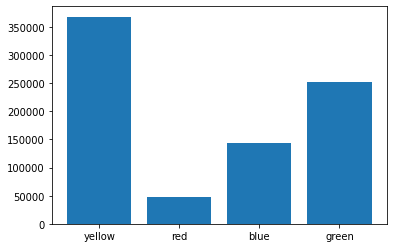

In [22]:
keys = dev_count.keys()
values = dev_count.values()

plt.bar(keys, values)

## Observations: 
1. both datasets follow the same distribution of classes. 
2. the classes are very unbalanced. With ```red``` being the one with less examples. 

## Problem: Defining what zero means 
How much close to zero can we consider a value as zero? This might make a lot of difference on the class distribution. e.g. 0.01 should be seen as zero? 

# Creating a baseline model (Dummy model)

## Checking the data distribution of test set (made of 20% of dev set)

<BarContainer object of 4 artists>

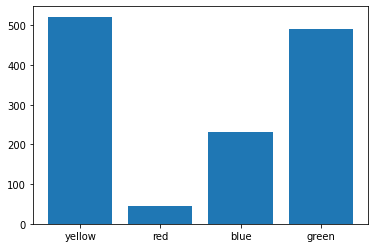

In [13]:
import matplotlib.pyplot as plt
y_test_count = y_test.value_counts()


test_count = {}
test_count['yellow'] = y_test_count['yellow']
test_count['red'] = y_test_count['red'] 
test_count['blue'] = y_test_count['blue'] 
test_count['green'] = y_test_count['green'] 

keys = test_count.keys()
values = test_count.values()

plt.bar(keys, values)


## Baseline model - most frequent prediction always

### 1. Accuracy

In [9]:
from sklearn.dummy import DummyClassifier
import pandas as pd
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split

DATASET_VIDEO_FOLDER = '/Users/user/PycharmProjects/emotion_detection_system/dataset/video'

x = pd.read_csv(f'{DATASET_VIDEO_FOLDER}/AU_train.csv').iloc[:, 2:-1]
y = pd.read_csv(f'{DATASET_VIDEO_FOLDER}/AU_train.csv')['emotion_zone']

x_dev_dataset = pd.read_csv(f'{DATASET_VIDEO_FOLDER}/AU_dev.csv').iloc[:, 2:-1]
y_dev_dataset = pd.read_csv(f'{DATASET_VIDEO_FOLDER}/AU_dev.csv')['emotion_zone']
x_dev, x_test = train_test_split(x_dev_dataset, test_size=0.2)
y_dev, y_test = train_test_split(y_dev_dataset, test_size=0.2)
dummy_clf = DummyClassifier(strategy="most_frequent")
# dummy_clf = DummyClassifier(strategy="uniform")
dummy_clf.fit(x, y)
predictions = dummy_clf.predict(x_test)
accuracy = accuracy_score(y_test, predictions)
accuracy

0.42979053529868116

### 2. Confusion Matrix

In [10]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions, labels=["blue", "green", "yellow", "red"])

array([[  0,   0, 230,   0],
       [  0,   0, 461,   0],
       [  0,   0, 554,   0],
       [  0,   0,  44,   0]])

## Baseline model - uniform random prediction
### 1. Accuracy

In [12]:
from sklearn.dummy import DummyClassifier
import pandas as pd
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split

DATASET_VIDEO_FOLDER = '/Users/user/PycharmProjects/emotion_detection_system/dataset/video'

x = pd.read_csv(f'{DATASET_VIDEO_FOLDER}/AU_train.csv').iloc[:, 2:-1]
y = pd.read_csv(f'{DATASET_VIDEO_FOLDER}/AU_train.csv')['emotion_zone']

x_dev_dataset = pd.read_csv(f'{DATASET_VIDEO_FOLDER}/AU_dev.csv').iloc[:, 2:-1]
y_dev_dataset = pd.read_csv(f'{DATASET_VIDEO_FOLDER}/AU_dev.csv')['emotion_zone']
x_dev, x_test = train_test_split(x_dev_dataset, test_size=0.2)
y_dev, y_test = train_test_split(y_dev_dataset, test_size=0.2)
dummy_clf = DummyClassifier(strategy="uniform")
dummy_clf.fit(x, y)
predictions = dummy_clf.predict(x_test)
accuracy = accuracy_score(y_test, predictions)
accuracy

0.24903025601241272

### 2. Confusion Matrix

In [13]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions, labels=["blue", "green", "yellow", "red"])

array([[ 61,  62,  57,  63],
       [121, 104, 110, 120],
       [132, 128, 148, 140],
       [  8,  19,   8,   8]])

## ED model - Using SVM - Video input + AU features
1. Only Video modality 
2. Only AU features 

### 1. Accuracy

The accuracy obtained is greater than a random guess and less than always guessing on the most frequent in the dataset. 

In [4]:
from sklearn import svm
clf = svm.SVC()
clf.fit(x, y)

predictions = clf.predict(x_test)
accuracy = accuracy_score(y_test, predictions)
print(f'Accuracy of SVM model: {accuracy}')

Accuracy of SVM model: 0.39332816136539955


### 2. Confusion matrix

As expected, the class more corrected predicted is ```yellow```. 

In [7]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions, labels=["blue", "green", "yellow", "red"])

array([[  9,  56, 169,   5],
       [ 24,  89, 340,   8],
       [ 25, 101, 409,  11],
       [  3,   4,  36,   0]])

## ED model - Using SVM - Video input + appearance features
1. Only Video modality 
2. Only appearance features 

### 1. Accuracy

In [6]:
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn import svm

from sklearn.model_selection import train_test_split

DATASET_VIDEO_FOLDER = '/Users/user/PycharmProjects/emotion_detection_system/dataset/video'

def run_model_one_feature(video_feature, model):
    x = pd.read_csv(f'{DATASET_VIDEO_FOLDER}/{video_feature}_train.csv').iloc[:, 2:-1]
    y = pd.read_csv(f'{DATASET_VIDEO_FOLDER}/{video_feature}_train.csv')['emotion_zone']
    x_dev_dataset = pd.read_csv(f'{DATASET_VIDEO_FOLDER}/{video_feature}_dev.csv').iloc[:, 2:-1]
    y_dev_dataset = pd.read_csv(f'{DATASET_VIDEO_FOLDER}/{video_feature}_dev.csv')['emotion_zone']
    x_dev, x_test = train_test_split(x_dev_dataset, test_size=0.2)
    y_dev, y_test = train_test_split(y_dev_dataset, test_size=0.2)

    if model == 'SVM':
        clf = svm.SVC()
    clf.fit(x, y)

    predictions = clf.predict(x_test)
    accuracy = accuracy_score(y_test, predictions)
    print(f'Accuracy of SVM model: {accuracy}')

    return predictions, y_test

predictions, y_test = run_model_one_feature('appearance', 'SVM')


Accuracy of SVM model: 0.42096774193548386


### 2. Confusion matrix

In [8]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions, labels=["blue", "green", "yellow", "red"])

array([[  6,  34, 160,   0],
       [ 12,  68, 381,   0],
       [ 14,  76, 448,   0],
       [  2,   4,  35,   0]])

## ED model - Using SVM - Video input + BoVW features
1. Only Video modality 
2. Only BoVW features 

### 1. Accuracy

In [12]:
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn import svm

from sklearn.model_selection import train_test_split

DATASET_VIDEO_FOLDER = '/Users/user/PycharmProjects/emotion_detection_system/dataset/video'

def run_model_one_feature(video_feature, model):
    x = pd.read_csv(f'{DATASET_VIDEO_FOLDER}/{video_feature}_train.csv').iloc[:, 2:-1]
    y = pd.read_csv(f'{DATASET_VIDEO_FOLDER}/{video_feature}_train.csv')['emotion_zone']
    x_dev_dataset = pd.read_csv(f'{DATASET_VIDEO_FOLDER}/{video_feature}_dev.csv').iloc[:, 2:-1]
    y_dev_dataset = pd.read_csv(f'{DATASET_VIDEO_FOLDER}/{video_feature}_dev.csv')['emotion_zone']
    x_dev, x_test = train_test_split(x_dev_dataset, test_size=0.2)
    y_dev, y_test = train_test_split(y_dev_dataset, test_size=0.2)

    if model == 'SVM':
        clf = svm.SVC()
    clf.fit(x, y)

    predictions = clf.predict(x_test)
    accuracy = accuracy_score(y_test, predictions)
    print(f'Accuracy of SVM model: {accuracy}')

    return predictions, y_test

predictions, y_test = run_model_one_feature('BoVW', 'SVM')

Accuracy of SVM model: 0.3809171597633136


### 2. Confusion Matrix

In [13]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions, labels=["blue", "green", "yellow", "red"])

array([[  4,  59, 228,   1],
       [ 11, 125, 358,   2],
       [  7, 136, 386,   1],
       [  0,   8,  26,   0]])

## ED model - Using SVM - Video input + (AU + appearance) features

1. Only Video modality 
2. AU and appearance features 

### 1. Accuracy

In [9]:
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn import svm
import functools
import glob

from sklearn.model_selection import train_test_split

DATASET_VIDEO_FOLDER = '/Users/user/PycharmProjects/emotion_detection_system/dataset/video'

def concatenate_video_au_files(dataset_type, features_type):
    """
    dataset_type must be 'train' or 'dev'
    """
    files = glob.glob(f'{DATASET_VIDEO_FOLDER}/{features_type}/{dataset_type}_*.csv')

    dfs = []
    for file in files:
        df = pd.read_csv(file)
        dfs.append(df)

    concated = pd.concat(dfs)
    concated.to_csv(f'{DATASET_VIDEO_FOLDER}/{features_type}_{dataset_type}.csv')

def concatenate_different_features_type_dataset(dataset_type, features_type_list):
    """
    dataset_type must be 'train' or 'dev'
    """
    files = glob.glob(f'{DATASET_VIDEO_FOLDER}/{features_type_list[0]}/{dataset_type}_*.csv')

    for file in files:
        dfs = []
        file_name = file.split('/')[-1]
        df = pd.read_csv(file).iloc[:, :-1]
        other_df_path = f'{DATASET_VIDEO_FOLDER}/{features_type_list[1]}/{file_name}'
        other_df = pd.read_csv(other_df_path)
        dfs.append(df)
        dfs.append(other_df)
        merged = functools.reduce(lambda df1, df2: pd.merge(df1, df2, on='frametime', how='inner'), dfs)
        # print(merged)
        merged.to_csv(f'{DATASET_VIDEO_FOLDER}/temp/{file_name}', index=False)

def producing_more_than_one_features_type(feature_type_lst):
    concatenate_different_features_type_dataset('train', feature_type_lst)
    concatenate_different_features_type_dataset('dev', feature_type_lst)
    concatenate_video_au_files('train', 'temp')
    concatenate_video_au_files('dev', 'temp')

def run_model_one_feature_type(video_feature, model):
    x = pd.read_csv(f'{DATASET_VIDEO_FOLDER}/{video_feature}_train.csv').iloc[:, 2:-1]
    y = pd.read_csv(f'{DATASET_VIDEO_FOLDER}/{video_feature}_train.csv')['emotion_zone']
    x_dev_dataset = pd.read_csv(f'{DATASET_VIDEO_FOLDER}/{video_feature}_dev.csv').iloc[:, 2:-1]
    y_dev_dataset = pd.read_csv(f'{DATASET_VIDEO_FOLDER}/{video_feature}_dev.csv')['emotion_zone']
    x_dev, x_test = train_test_split(x_dev_dataset, test_size=0.2)
    y_dev, y_test = train_test_split(y_dev_dataset, test_size=0.2)

    if model == 'SVM':
        clf = svm.SVC()
    clf.fit(x, y)

    predictions = clf.predict(x_test)
    accuracy = accuracy_score(y_test, predictions)
    print(f'Accuracy of SVM model: {accuracy}')
    return predictions, y_test 


def run_model_more_than_one_feature_type(feature_type_list, model):
    producing_more_than_one_features_type(feature_type_list)
    predictions, y_test  = run_model_one_feature_type('temp', model)
    return predictions, y_test 


feature_type_list = ['AU', 'appearance']
predictions, y_test = run_model_more_than_one_feature_type(feature_type_list, 'SVM')

Accuracy of SVM model: 0.43842364532019706


### 2. Confusion matrix

In [11]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions, labels=["blue", "green", "yellow", "red"])

array([[  8,  50, 164,   1],
       [ 19,  71, 308,   1],
       [ 19,  87, 455,   0],
       [  1,   8,  26,   0]])

## ED model - Using SVM - Video input + (AU + appearance + BoVW) features

1. Only Video modality 
2. AU, appearance and BoVW features 

### 1. Accuracy

In [16]:
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn import svm
import functools
import glob

from sklearn.model_selection import train_test_split

DATASET_VIDEO_FOLDER = '/Users/user/PycharmProjects/emotion_detection_system/dataset/video'

def concatenate_video_au_files(dataset_type, features_type):
    """
    dataset_type must be 'train' or 'dev'
    """
    files = glob.glob(f'{DATASET_VIDEO_FOLDER}/{features_type}/{dataset_type}_*.csv')

    dfs = []
    for file in files:
        df = pd.read_csv(file)
        dfs.append(df)

    concated = pd.concat(dfs)
    concated.to_csv(f'{DATASET_VIDEO_FOLDER}/{features_type}_{dataset_type}.csv')

def concatenate_different_features_type_dataset(dataset_type, features_type_list):
    """
    dataset_type must be 'train' or 'dev'
    """

    files = glob.glob(f'{DATASET_VIDEO_FOLDER}/{features_type_list[0]}/{dataset_type}_*.csv')

    for file in files[:]:
        dfs = []
        file_name = file.split('/')[-1]
        # df = pd.read_csv(file).iloc[:, :-1]
        # dfs.append(df)
        for i, feature_type in enumerate(features_type_list):
            if i < len(features_type_list) - 1:
                other_df_path = f'{DATASET_VIDEO_FOLDER}/{features_type_list[i]}/{file_name}'
                other_df = pd.read_csv(other_df_path).iloc[:, :-1]
                dfs.append(other_df)
            else:
                last_df_path = f'{DATASET_VIDEO_FOLDER}/{features_type_list[-1]}/{file_name}'
                last_df_path = pd.read_csv(last_df_path)
                dfs.append(last_df_path)

        merged = functools.reduce(lambda df1, df2: pd.merge(df1, df2, on='frametime', how='inner'), dfs)
        # print(merged)
        merged.to_csv(f'{DATASET_VIDEO_FOLDER}/temp/{file_name}', index=False)

def producing_more_than_one_features_type(feature_type_lst):
    concatenate_different_features_type_dataset('train', feature_type_lst)
    concatenate_different_features_type_dataset('dev', feature_type_lst)
    concatenate_video_au_files('train', 'temp')
    concatenate_video_au_files('dev', 'temp')

def run_model_one_feature_type(video_feature, model):
    x = pd.read_csv(f'{DATASET_VIDEO_FOLDER}/{video_feature}_train.csv').iloc[:, 2:-1]
    y = pd.read_csv(f'{DATASET_VIDEO_FOLDER}/{video_feature}_train.csv')['emotion_zone']
    x_dev_dataset = pd.read_csv(f'{DATASET_VIDEO_FOLDER}/{video_feature}_dev.csv').iloc[:, 2:-1]
    y_dev_dataset = pd.read_csv(f'{DATASET_VIDEO_FOLDER}/{video_feature}_dev.csv')['emotion_zone']
    x_dev, x_test = train_test_split(x_dev_dataset, test_size=0.2)
    y_dev, y_test = train_test_split(y_dev_dataset, test_size=0.2)

    if model == 'SVM':
        clf = svm.SVC()
    clf.fit(x, y)

    predictions = clf.predict(x_test)
    accuracy = accuracy_score(y_test, predictions)
    print(f'Accuracy of SVM model: {accuracy}')
    return predictions, y_test 


def run_model_more_than_one_feature_type(feature_type_list, model):
    producing_more_than_one_features_type(feature_type_list)
    predictions, y_test  = run_model_one_feature_type('temp', model)
    return predictions, y_test 


feature_type_list = ['AU', 'appearance', 'BoVW']
predictions, y_test = run_model_more_than_one_feature_type(feature_type_list, 'SVM')

Accuracy of SVM model: 0.4006568144499179


### 2. Confusion matrix

In [18]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions, labels=["blue", "green", "yellow", "red"])

array([[  3,  46, 167,   0],
       [  9,  94, 355,   0],
       [ 14, 100, 391,   0],
       [  0,   7,  32,   0]])

### Model with video (AU + appearance + BoVW features) - SVM 

#### Accuracy of SVM model: 0.4302134646962233

#### Confusion matrix: labels=["blue", "green", "yellow", "red"]
```
[[  6  42 167   0]
 [ 15 108 326   0]
 [ 17  92 410   0]
 [  1   9  25   0]]```

### Model with video (AU  + BoVW features) - SVM 

#### Accuracy of SVM model: 0.395655546935609

#### Confusion matrix: labels=["blue", "green", "yellow", "red"]
 
```
[[  9  63 191   1]
 [ 14 117 317   0]
 [ 12 141 384   2]
 [  4   6  28   0]]```

### Model with video (geometric features) - SVM 

#### Accuracy of SVM model: 0.4324960753532182

#### Confusion matrix: labels=["blue", "green", "yellow", "red"]
 
```
[[  0   5 232   0]
 [  0   8 433   0]
 [  0   6 543   0]
 [  0   3  44   0]]
```

### Model with video (AU + appearance + BoVW + geometric features) - SVM 

#### Accuracy of SVM model: 0.4324960753532182

#### Confusion matrix: labels=["blue", "green", "yellow", "red"]
 
```
[[  0   4 208   0]
 [  0   8 422   0]
 [  0  11 530   0]
 [  0   0  35   0]]
```

### Model with video (AU + geometric features) - SVM 

#### Accuracy of SVM model: 0.41626409017713367

#### Confusion matrix: labels=["blue", "green", "yellow", "red"]
 
```
[[  0   5 222   0]
 [  0   5 454   0]
 [  0   7 512   0]
 [  0   1  36   0]]
```

Accuracy of SVM model for video modality using ['AU', 'geometric'] as features: 0.4331723027375201
```
[[  0   7 213   0]
 [  0  11 432   0]
 [  0   8 527   0]
 [  0   1  43   0]]
 ```
 
 Accuracy of SVM model for video modality using ['AU', 'geometric'] as features: 0.4420289855072464

Confusion matrix: labels=["blue", "green", "yellow", "red"]
```
[[  0   5 219   0]
 [  0  12 416   0]
 [  0  10 537   0]
 [  0   1  42   0]]
 ```

### Model with AUDIO (BoAW) - SVM 

#### Accuracy of SVM model: 0.4066666666666667

#### Confusion matrix: labels=["blue", "green", "yellow", "red"]
 
```
[[  5  78 164   0]
 [  4 166 327   0]
 [  6 179 378   0]
 [  0  18  25   0]]
```

# 13/07/2020
# Regenerating all results: 
Because there was a bug on the dev/test dataset split, making that the annotation from the testset wasn't correct. 

## Processing the input: {'modalities': {'video': {'features_type': {'AU': True, 'appearance': False, 'BoVW': False, 'geometric': False}, 'model': 'SVM'}}, 'fusion_type': 'late_fusion'}


Accuracy: 0.39875872769588827

Confusion matrix: labels=["blue", "green", "yellow", "red"]
```
[[  4  67 195   0]
 [ 34  95 318   8]
 [ 30  76 414  14]
 [  0   5  28   1]]
 ```

## Processing the input: {'modalities': {'video': {'features_type': {'AU': False, 'appearance': True, 'BoVW': False, 'geometric': False}, 'model': 'SVM'}}, 'fusion_type': 'late_fusion'}

Accuracy: 0.3758064516129032

Confusion matrix: labels=["blue", "green", "yellow", "red"]
```
[[  5  45 177   0]
 [ 17  63 381   0]
 [ 14 101 398   0]
 [  4   7  28   0]]```

## Processing the input: {'modalities': {'video': {'features_type': {'AU': False, 'appearance': False, 'BoVW': True, 'geometric': False}, 'model': 'SVM'}}, 'fusion_type': 'late_fusion'}

Accuracy: 0.40458579881656803

Confusion matrix: labels=["blue", "green", "yellow", "red"]
```
[[  8  64 190   3]
 [  6 115 360   0]
 [ 12 131 424   2]
 [  0  10  27   0]]```

## Processing the input: {'modalities': {'video': {'features_type': {'AU': False, 'appearance': False, 'BoVW': False, 'geometric': True}, 'model': 'SVM'}}, 'fusion_type': 'late_fusion'}

Accuracy: 0.41836734693877553

Confusion matrix: labels=["blue", "green", "yellow", "red"]
```
[[  0  10 238   0]
 [  0   1 435   0]
 [  0   9 532   0]
 [  0   1  48   0]]```

## Processing the input: {'modalities': {'video': {'features_type': {'AU': True, 'appearance': True, 'BoVW': True, 'geometric': True}, 'model': 'SVM'}}, 'fusion_type': 'late_fusion'}

Accuracy: 0.4236453201970443

Confusion matrix: labels=["blue", "green", "yellow", "red"]
```
[[  0   6 215   0]
 [  0   8 430   0]
 [  0   7 508   0]
 [  0   1  43   0]]```

## Processing the input: {'modalities': {'audio': {'features_type': {'BoAW': True}, 'model': 'SVM'}}, 'fusion_type': 'late_fusion'}

Accuracy: 0.5044444444444445

Confusion matrix: labels=["blue", "green", "yellow", "red"]
```
[[  4 106 149   0]
 [  3 255 275   1]
 [  5  92 422   0]
 [  0  10  28   0]]```

## Processing the input: {'modalities': {'audio': {'features_type': {'BoAW': False, 'DeepSpectrum': True, 'eGeMAPSfunct': False}, 'model': 'SVM'}}, 'fusion_type': 'late_fusion'}

Accuracy: 0.4703703703703704

Confusion matrix: labels=["blue", "green", "yellow", "red"]
```
[[  0 137 130   0]
 [  0 227 269   0]
 [  0 133 408   0]
 [  0  14  32   0]]```


## Processing the input: {'modalities': {'video': {'features_type': {'AU': True, 'appearance': True, 'BoVW': True, 'geometric': True}, 'model': 'SVM'}, 'audio': {'features_type': {'BoAW': True}, 'model': 'SVM'}}, 'fusion_type': 'late_fusion'}

Accuracy: 0.4734848484848485

Confusion matrix: labels=["blue", "green", "yellow", "red"]
```
[[  1  16  39   0]
 [  0  21  63   0]
 [  0  13 103   0]
 [  0   0   8   0]]```

## Processing the input: {'modalities': {'video': {'features_type': {'AU': False, 'appearance': False, 'BoVW': False, 'geometric': True}, 'model': 'SVM'}, 'audio': {'features_type': {'BoAW': True}, 'model': 'SVM'}}, 'fusion_type': 'late_fusion'}

Accuracy: 0.4461538461538462

Confusion matrix: labels=["blue", "green", "yellow", "red"]
```
[[ 0  9 44  0]
 [ 0 20 71  0]
 [ 0 11 96  0]
 [ 0  3  6  0]]```

### Note that when using multimodal (the two results above), the number of examples for testset is way smaller (the sum of all numbers of the confusion matrix). 

This happens because, in the moment, the multimodality is a random selection of one of the two possible prediction modality - one coming from video and another from audio. 
To do this, the test dataset is the intersection of the frametime with avaliable features of video and audio. 

Since we do not have valid features for each frametime in the dataset for each modality, the intersection of the two modalities generates a testdataset smaller than using only one modality. 

### What can be done? 

I can include into the testset examples of when I have the prediction of only one modality available. 
So instead of being the intersection, it will be the union of the two modalitites. 

## Processing the input: {'modalities': {'video': {'features_type': {'AU': True, 'appearance': False, 'BoVW': False, 'geometric': False}, 'model': 'SVM'}, 'audio': {'features_type': {'BoAW': True}, 'model': 'SVM'}}, 'fusion_type': 'late_fusion'}

Accuracy: 0.45867768595041325

Confusion matrix: labels=["blue", "green", "yellow", "red"]
```
[[ 0 12 28  0]
 [ 4 28 58  1]
 [ 5 12 83  3]
 [ 0  3  5  0]]```

# Balancing the dataset
## 1. First method: undersampling 

## Using balanced training set of total of 1392 examples. 
348 examples of each class

## Processing the input: {'modalities': {'video': {'features_type': {'AU': True, 'appearance': False, 'BoVW': False, 'geometric': False}, 'model': 'SVM'}}, 'fusion_type': 'late_fusion'}

Accuracy: 0.2699767261442979

Confusion matrix: labels=["blue", "green", "yellow", "red"]
```
[[ 45 101  68  41]
 [118 121 117 111]
 [116 106 181 126]
 [  5  10  22   1]]```


## Using balanced training set of total of 1540 examples. 
385 examples of each class

## Processing the input: {'modalities': {'audio': {'features_type': {'BoAW': False, 'DeepSpectrum': False, 'eGeMAPSfunct': True}, 'model': 'SVM'}}, 'fusion_type': 'late_fusion'}

Accuracy: 0.2952167414050822

Confusion matrix: labels=["blue", "green", "yellow", "red"]
```
[[ 83 117  12  27]
 [150 265  31  42]
 [140 299  47  78]
 [ 15  29   3   0]]```

## Using balanced training set of total of 1588 examples. 
397 examples of each class

## Processing the input: {'modalities': {'audio': {'features_type': {'BoAW': True, 'DeepSpectrum': False, 'eGeMAPSfunct': False}, 'model': 'SVM'}}, 'fusion_type': 'late_fusion'}

Accuracy: 0.42444444444444446

Confusion matrix: labels=["blue", "green", "yellow", "red"]
```
[[ 40 118  68  31]
 [ 83 247 115  36]
 [ 51 151 280  79]
 [  3  13  29   6]]```

# Result using two modalities and processing the union of examples of each modality, i.e. if some modality is unavailable, the result of the other modality is used. If both modality are available, we radomly select one of them to be the predicted result. 
We obtain higher accuracy this way. 


## VIDEO
Using balanced training set of total of 1392 examples. 
348 examples of each class

## AUDIO
Using balanced training set of total of 1540 examples. 
385 examples of each class

## Processing the input: {'modalities': {'video': {'features_type': {'AU': True, 'appearance': False, 'BoVW': False, 'geometric': False}, 'model': 'SVM'}, 'audio': {'features_type': {'BoAW': False, 'DeepSpectrum': False, 'eGeMAPSfunct': True}, 'model': 'SVM'}}, 'fusion_type': 'late_fusion'}


Accuracy: 0.627712219261515

Confusion matrix: labels=["blue", "green", "yellow", "red"]
```
[[ 35  92  86  50]
 [111 136 130  98]
 [133 117 136 138]
 [  4  14   5   4]]```




OBS: The audio feature type DeepSpectrum cannot be used with other audio features, because they do note share the same timeframes. The annotators created this feature using frametimes of 400ms but starting from 1.0 not 0.0 (as the other features). We still have annotation for those frametimes, thus DeepSpectrum feature works alone or together with video features. 

## Using balanced training set of total of 908 examples. 
227 examples of each class

## Processing the input: {'modalities': {'physio': {'features_type': {'HRHRV': True}, 'model': 'SVM'}}, 'fusion_type': 'late_fusion'}

Accuracy: 0.3484646194926569

Confusion matrix: labels=["blue", "green", "yellow", "red"]
```
[[  8  40  92  18]
 [ 51 102 107  43]
 [ 23  70 148  27]
 [  4   5   8   3]]```

## Using balanced training set of total of 1392 examples. 
348 examples of each class

## Processing the input: {'modalities': {'video': {'features_type': {'AU': True, 'appearance': False, 'BoVW': True, 'geometric': False}, 'model': 'SVM'}}, 'fusion_type': 'late_fusion'}

Accuracy: 0.360744763382467

Confusion matrix: labels=["blue", "green", "yellow", "red"]
```
[[ 45 120  76  20]
 [108 154 150  39]
 [110 110 263  51]
 [ 13  12  15   3]]```

## 14th September 2020 

Implementing Manel's idea of only getting values of emotions that are aaway from the axis, trying to avoid points of confusion between emotion classes. 

I createad an area that will be discarted with the value of threshold of X (variable) 

If x or y (valence or arousal) are less than the threshold value, we discard the value, the example from the dataset. Not considering that emotion as valid. 



In [9]:
import glob
import pathlib
import os.path

import pandas as pd

path_annotation_emotions = '/Users/user/PycharmProjects/emotion_detection_system/labels/emotion_zones/advanced_mapping'
# path_annotation_emotions = '/Users/user/PycharmProjects/emotion_detection_system/labels/emotion_zones/emotion_names'
files = glob.glob(f"{path_annotation_emotions}/*.csv")
train_count = {'yellow': 0, 'red': 0, 'blue': 0, 'green': 0}
dev_count = {'yellow': 0, 'red': 0, 'blue': 0, 'green': 0}
for file in files:
    df_train = pd.read_csv(file)
    df_train['emotion_zone'].value_counts()
    count_emotions = df_train['emotion_zone'].value_counts()
    print(count_emotions)
    if 'train' in file:
        try:
            train_count['yellow'] += count_emotions['yellow']
        except:
            pass
        try:
            train_count['red'] += count_emotions['red']
        except:
            pass
        try:
            train_count['blue'] += count_emotions['blue']
        except:
            pass
        try:
            train_count['green'] += count_emotions['green']
        except:
            pass
    elif 'dev' in file:
        try: 
            dev_count['yellow'] += count_emotions['yellow']
        except:
            pass
        try: 
            dev_count['red'] += count_emotions['red']
        except:
            pass
        try: 
            dev_count['blue'] += count_emotions['blue']
        except:
            pass
        try: 
            dev_count['green'] += count_emotions['green']
        except:
            pass
print(train_count)
print(dev_count)

yellow    1084
green      107
red         99
blue         1
Name: emotion_zone, dtype: int64
yellow    1709
green      141
Name: emotion_zone, dtype: int64
yellow    3870
green      952
blue       151
Name: emotion_zone, dtype: int64
green     1072
yellow     456
Name: emotion_zone, dtype: int64
yellow    1750
green      207
red        126
Name: emotion_zone, dtype: int64
yellow    1171
green      384
Name: emotion_zone, dtype: int64
yellow    2639
green      451
Name: emotion_zone, dtype: int64
green     935
yellow    834
blue      145
Name: emotion_zone, dtype: int64
yellow    3033
red        221
blue        78
green       72
Name: emotion_zone, dtype: int64
yellow    2980
green        2
Name: emotion_zone, dtype: int64
blue      399
yellow     15
green       5
Name: emotion_zone, dtype: int64
yellow    1833
green      637
Name: emotion_zone, dtype: int64
blue      345
yellow    117
green      86
Name: emotion_zone, dtype: int64
blue      945
yellow    523
green     315
Name: emotion

![GitHub Logo](emotion_mapping.jpeg)

![GitHub Logo](emotion_mapping_manel_idea.jpeg)

## 1. Using the threshold value as 0.25 

{'yellow': 2487, 'red': 0, 'blue': 0, 'green': 142}

{'yellow': 1335, 'red': 0, 'blue': 0, 'green': 0}



<BarContainer object of 4 artists>

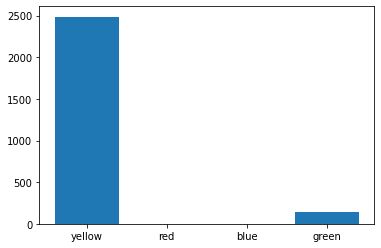

In [6]:
import matplotlib.pyplot as plt
keys = train_count.keys()
values = train_count.values()

plt.bar(keys, values)

<BarContainer object of 4 artists>

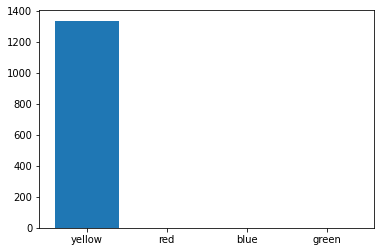

In [5]:
import matplotlib.pyplot as plt
keys = dev_count.keys()
values = dev_count.values()

plt.bar(keys, values)

## 2. Using the threshold value as 0.1

{'yellow': 18621, 'red': 446, 'blue': 424, 'green': 4047}

{'yellow': 12970, 'red': 0, 'blue': 1640, 'green': 4317}



<BarContainer object of 4 artists>

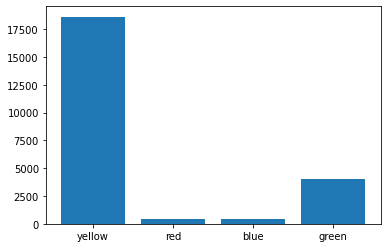

In [10]:
import matplotlib.pyplot as plt
keys = train_count.keys()
values = train_count.values()

plt.bar(keys, values)

<BarContainer object of 4 artists>

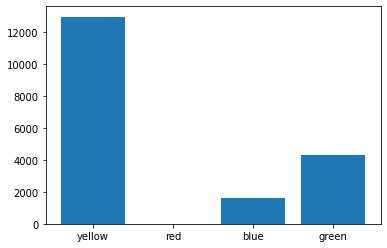

In [11]:
import matplotlib.pyplot as plt
keys = dev_count.keys()
values = dev_count.values()

plt.bar(keys, values)

Conclusion: the distribution continue to be the same, but the number of examples drop a lot. 
Is it worth to do it anyway? 

## 10th May 2021
Distribution of Valence / Arousal in RECOLA 

True


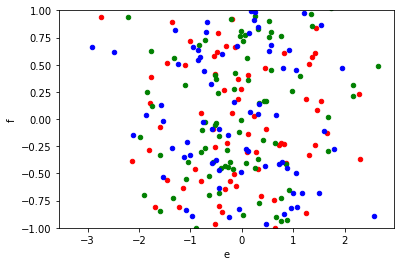

In [5]:
# var = 'GrLivArea'
# data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
# data.plot.scatter(x='Valence', y='Arousal', ylim=(-1,1), s=32, c='#80a4d1');


import pandas as pd
import numpy as np
import seaborn as sns

df = pd.DataFrame(np.random.randn(100, 6), columns=['a', 'b', 'c', 'd', 'e', 'f'])
# df = pd.rea


ax1 = df.plot(kind='scatter', x='a', y='b', color='r', ylim=(-1,1))    
ax2 = df.plot(kind='scatter', x='c', y='d', color='g', ax=ax1)    
ax3 = df.plot(kind='scatter', x='e', y='f', color='b', ax=ax1)

print(ax1 == ax2 == ax3)  # True

[(-1.0, 1.0)]

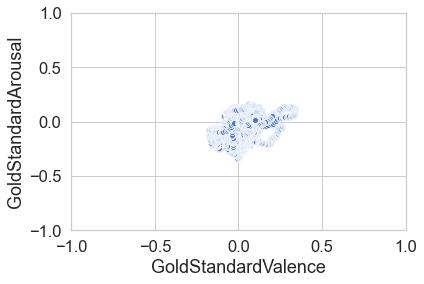

In [27]:
import pandas as pd
import numpy as np
import seaborn as sns

sns.set(style='whitegrid', palette='muted',font_scale=1.5)
df = pd.read_csv('/Users/user/PycharmProjects/emotion_detection_system/labels/combined_valence_arousal/train_1.csv')

# tips = sns.load_dataset("tips")
g = sns.scatterplot(data=df, x="GoldStandardValence", y="GoldStandardArousal")
g.set(ylim=(-1,1))
g.set(xlim=(-1,1))

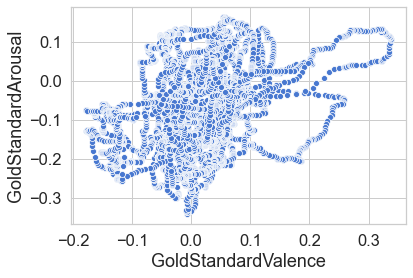

In [28]:
import pandas as pd
import numpy as np
import seaborn as sns

sns.set(style='whitegrid', palette='muted',font_scale=1.5)
df = pd.read_csv('/Users/user/PycharmProjects/emotion_detection_system/labels/combined_valence_arousal/train_1.csv')

# tips = sns.load_dataset("tips")
g = sns.scatterplot(data=df, x="GoldStandardValence", y="GoldStandardArousal")